### Faster RCNN

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install pytorch-gradcam
!pip install grad-cam
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [3]:
import torch
from collections import namedtuple
import abc, cv2, glob,copy
import torch, os, json
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import defaultdict
import torchvision
from torchvision import ops
import matplotlib.patches as patches
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import csv
from collections import Counter

import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import (
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
import warnings
from pycocotools.coco import COCO
import random
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
COCOBox_base = namedtuple("COCOBox", ["xmin", "ymin", "width", "height"])
VOCBox_base = namedtuple("VOCBox", ["xmin", "ymin", "xmax", "ymax"])

class COCOBox(COCOBox_base):
    def area(self):
        return self.width * self.height


class VOCBox(VOCBox_base):
    def area(self):
        return (self.xmax - self.xmin) * (self.ymax - self.ymin)


# Define the abstract base class for loading datasets
class DatasetLoader(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def load_images(self):
        pass

    @abc.abstractmethod
    def load_annotations(self):
        pass


In [6]:
class CocoDataset(Dataset):
    def __init__(self, image_folder, annotations_file, width, height, transforms=None):

        self.transforms = transforms
        self.image_folder = image_folder
        self.annotations_file = annotations_file
        self.height = height
        self.width = width

        if not isinstance(self.image_folder, str):
            raise ValueError("image_folder should be a string")

        if not isinstance(annotations_file, str):
            raise ValueError("annotations_file should be a string")

        self.annotations_file = annotations_file
        self.image_folder = image_folder
        self.width = width
        self.height = height

        with open(annotations_file, "r") as f:
            self.annotations = json.load(f)

        self.image_ids = defaultdict(list)
        for i in self.annotations["images"]:
            self.image_ids[i["id"]] = i  # key = image_id

        self.annotation_ids = defaultdict(list)
        for i in self.annotations["annotations"]:
            self.annotation_ids[i["image_id"]].append(i)  # key = image_id

        self.cats_id2label = {}
        self.label_names = []

        first_label_id = self.annotations["categories"][0]["id"]
        if first_label_id == 0:
            for i in self.annotations["categories"][1:]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        if first_label_id == 1:
            for i in self.annotations["categories"]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        if first_label_id > 1:
            raise AssertionError(
                "Something went wrong in categories, check the annotation file!"
            )

    def get_total_classes_count(self):
        return len(self.cats_id2label)

    def get_classnames(self):
        return [v for k, v in self.cats_id2label.items()]

    def load_images_annotations(self, index):
        image_info = self.image_ids[index]
        image_path = os.path.join(self.image_folder, image_info["file_name"])

        image = cv2.imread(image_path)
        rimage = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )  # .astype(np.float32) # convert BGR to RGB color format
        rimage = cv2.resize(rimage, (self.width, self.height))
        # rimage /= 255.0
        rimage = Image.fromarray(rimage)

        image_height, image_width = (
            image_info["height"],
            image_info["width"],
        )  # original height & width
        anno_info = self.annotation_ids[index]

        if len(anno_info) == 0:  # for negative images (Images without annotations)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0, 1), dtype=torch.int64)
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = []
            labels_id = []

            for ainfo in anno_info:
                xmin, ymin, w, h = ainfo["bbox"]
                xmax, ymax = xmin + w, ymin + h

                xmin_final = (xmin / image_width) * self.width
                xmax_final = (xmax / image_width) * self.width
                ymin_final = (ymin / image_height) * self.height
                ymax_final = (ymax / image_height) * self.height

                category_id = ainfo["category_id"]

                boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
                labels_id.append(category_id)

            boxes = torch.as_tensor(
                boxes, dtype=torch.float32
            )  # bounding box to tensor
            area = (boxes[:, 3] - boxes[:, 1]) * (
                boxes[:, 2] - boxes[:, 0]
            )  # area of the bounding boxes
            iscrowd = torch.zeros(
                (boxes.shape[0],), dtype=torch.int64
            )  # no crowd instances
            labels = torch.as_tensor(labels_id, dtype=torch.int64)  # labels to tensor

        # final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([index])
        target["image_id"] = image_id

        return {
            "image": rimage,
            "height": image_height,
            "width": image_width,
            "target": target,
        }

    @staticmethod
    def transform_image_for_inference(image_path,width,height):

        image = cv2.imread(image_path)
        ori_h, ori_w, _ = image.shape

        oimage = copy.deepcopy(image)
        oimage = Image.fromarray(oimage)
        oimage = T.ToTensor()(oimage)

        rimage = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )
        rimage = cv2.resize(rimage, (width,height))
        rimage = Image.fromarray(rimage)
        rimage = T.ToTensor()(rimage)
        # rimage = torch.unsqueeze(rimage, 0)

        transform_info = {'original_width':ori_w,
                          'original_height':ori_h,
                          'resized_width':width,
                          'resized_height':height,
                          'resized_image':rimage,
                          'original_image':oimage}

        return transform_info # this can directly go to model for inference

    @staticmethod
    def display_bbox(
        bboxes, fig, ax, classes=None, in_format="xyxy", color="y", line_width=3
    ):
        if type(bboxes) == np.ndarray:
            bboxes = torch.from_numpy(bboxes)
        if classes:
            assert len(bboxes) == len(classes)
        # convert boxes to xywh format
        bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt="xywh")
        c = 0
        for box in bboxes:
            x, y, w, h = box.numpy()
            # display bounding box
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=line_width, edgecolor=color, facecolor="none"
            )
            ax.add_patch(rect)
            # display category
            if classes:
                if classes[c] == "pad":
                    continue
                ax.text(
                    x + 5, y + 20, classes[c], bbox=dict(facecolor="yellow", alpha=0.5)
                )
            c += 1

        return fig, ax

    def __getitem__(self, idx):

        sample = self.load_images_annotations(idx)
        image_resized = sample["image"]
        target = sample["target"]

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=sample["labels"]
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return T.ToTensor()(image_resized), target

    def __len__(self):
        return len(self.image_ids)

In [7]:

def create_model(num_classes,checkpoint=None,device='cuda'):
    """
    Create a model for object detection using the Faster R-CNN architecture.

    Parameters:
    - num_classes (int): The number of classes for object detection. (Total classes + 1 [for background class])
    - checkpoint (str) : checkpoint path for the pretrained custom model
    - device (str) : cpu / cuda
    Returns:
    - model (torchvision.models.detection.fasterrcnn_resnet50_fpn): The created model for object detection.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True,
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        pretrained_backbone=True,
        #weights_backbone = 'ResNet50_Weights.DEFAULT',
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if checkpoint:
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model = model.to(device)
    return model


In [8]:
class InferFasterRCNN:
    def __init__(self, num_classes=None, classnames=[]):

        assert type(num_classes) != type(None), "Define number of classes"

        self.num_classes = num_classes  # total_class_no + 1 (for background)

        self.classnames = ["__background__"]
        self.classnames.extend(classnames)

        self.colors = np.random.uniform(0, 255, size=(len(self.classnames), 3))

        assert (
            len(self.classnames) == self.num_classes
        ), f"num_classes: {self.num_classes}, len(classnames): {len(self.classnames)}.\
            num_classes should be equal to count of actual classes in classnames list without background + 1"

    def load_model(self, checkpoint, device="cpu"):
        self.device = device
        self.model = create_model(
            self.num_classes, checkpoint=checkpoint, device=self.device
        )
        self.model = self.model.eval()

    def infer_image(self, transform_info ,detection_threshold=0.5, visualize=False):

        '''
        image : original unscaled image
        '''

        display_unscaled = True
        h_ratio = transform_info['original_height']/transform_info['resized_height']
        w_ratio = transform_info['original_width']/transform_info['resized_width']

        orig_image = transform_info['resized_image']
        orig_image = orig_image.cpu().numpy()
        orig_image = np.transpose(orig_image, (1, 2, 0))
        orig_image = np.ascontiguousarray(orig_image, dtype=np.float32)
        image = torch.unsqueeze(transform_info['resized_image'], 0)

        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]

        results = {}
        _f_boxes,_f_scores,_f_labels = [],[],[]

        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy() # xyxy
            scores = outputs[0]["scores"].data.numpy()
            labels = outputs[0]["labels"].cpu().numpy()

            # filter out boxes according to `detection_threshold`
            for i in range(len(boxes)):
                if scores[i] >= detection_threshold:
                    _f_boxes.append(boxes[i])
                    _f_labels.append(labels[i])
                    _f_scores.append(scores[i])

            boxes,labels,scores = _f_boxes,_f_labels,_f_scores
            #boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in labels
            ]

            results['unscaled_boxes'] = [[i[0]*w_ratio, i[1]*h_ratio, i[2]*w_ratio, i[3]*h_ratio] for i in boxes] # in original image size
            results['scaled_boxes'] = boxes # in resize image size
            results['scores'] = scores
            results['pred_classes'] = pred_classes
            results['labels'] = labels

            if not display_unscaled:
                # draw the bounding boxes and write the class name on top of it
                for j, box in enumerate(draw_boxes):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(orig_image[:,:,::-1])
                    plt.show()

            else:
                # draw the bounding boxes and write the class name on top of it
                draw_boxes_scaled = results['unscaled_boxes']
                scaled_orig_image = transform_info['original_image']
                scaled_orig_image = scaled_orig_image.cpu().numpy()
                scaled_orig_image = np.transpose(scaled_orig_image, (1, 2, 0))
                scaled_orig_image = np.ascontiguousarray(scaled_orig_image, dtype=np.float32)

                for j, box in enumerate(draw_boxes_scaled):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        scaled_orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        scaled_orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(scaled_orig_image)  # [:,:,::-1])
                    plt.show()

        return results

    def infer_image_path(self, image_path, detection_threshold=0.5, visualize=False):

        image = cv2.imread(image_path)
        orig_image = image.copy()

        # BGR to RGB
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # make the pixel range between 0 and 1
        image /= 255.0
        # bring color channels to front
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # convert to tensor
        image = torch.tensor(image, dtype=torch.float).cpu()

        # add batch dimension
        image = torch.unsqueeze(image, 0)
        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]


        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy()
            scores = outputs[0]["scores"].data.numpy()

            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in outputs[0]["labels"].cpu().numpy()
            ]

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                class_name = pred_classes[j]
                color = self.colors[self.classnames.index(class_name)]
                cv2.rectangle(
                    orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color,
                    2,
                )
                cv2.putText(
                    orig_image,
                    class_name,
                    (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    color,
                    2,
                    lineType=cv2.LINE_AA,
                )

            if visualize:
                plt.figure(figsize=(10, 10))
                plt.imshow(orig_image[:, :, ::-1])
                plt.show()

        return outputs


    def draw_bounding_boxes(self,image, bboxes, class_labels, figsize=(12,12)):
        class_labels = class_labels.cpu().numpy()
        bboxes = bboxes.cpu().numpy()
        for j, box in enumerate(bboxes):
            label = class_labels[j]
            color = self.colors[label]
            cv2.rectangle(
                    image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0,200,0),
                    1,
                )
            cv2.putText(
                image,
                self.classnames[int(label)],
                (int(box[0] + 15), int(box[1] + 15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0,200,0),
                2,
                lineType=cv2.LINE_AA,
            )

        plt.figure(figsize=figsize)
        plt.imshow(image)
        plt.show()

In [9]:

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """

    def __init__(
        self, best_valid_loss=float("inf"), output_dir="weight_outputs",
    ):
        self.best_valid_loss = best_valid_loss

        os.makedirs(output_dir, exist_ok=True)

        self.output_dir = output_dir

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                f"{self.output_dir}/best_model.pth",
            )

def display_gt_pred(image_path,
                    gt_boxes,
                    pred_boxes,
                    gt_class,
                    pred_class,
                    pred_scores,
                    box_format='xywh',
                    figsize=(10,10),
                    classnames = []):

    line_width = 1
    gt_color = 'g'
    pred_color = 'r'
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img[:,:,::-1])

    for gb,gc in zip(gt_boxes,gt_class):

        if format == 'xywh':
            x, y, w, h = gb

        if box_format == 'xyxy':
            x1, y1, x2, y2 = gb
            x,y,w,h = x1,y1,x2-x1,y2-y1

        rect = patches.Rectangle(
                (x, y), w, h, linewidth=line_width, edgecolor=gt_color, facecolor="none"
            )
        ax.add_patch(rect)

        if len(classnames)>0:
            ax.text(x + 5, y + 20, classnames[int(gc)-1], bbox=dict(facecolor="yellow", alpha=0.5))
        else:
            ax.text(x + 5, y + 20, gc, bbox=dict(facecolor="yellow", alpha=0.5))

    for pb,pc,ps in zip(pred_boxes,pred_class,pred_scores):
        if format == 'xywh':
            x, y, w, h = pb
        if box_format == 'xyxy':
            x1, y1, x2, y2 = pb
            x,y,w,h = x1,y1,x2-x1,y2-y1
        rect = patches.Rectangle(
                (x, y), w, h, linewidth=line_width+1, edgecolor=pred_color, facecolor="none"
            )
        ax.add_patch(rect)
        ax.text(x + 5, y + 40, f'{pc},{round(ps*100,2)}', bbox=dict(facecolor="red", alpha=0.5))

    plt.axis('off')
    plt.show()


## Accessing the class
class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
IF_C = InferFasterRCNN(num_classes=len(class_list) + 1,
                       classnames=class_list)
IF_C.load_model(checkpoint=r'D:/yolo/v8_cam/best_model.pth',
                device=device)

### Get prediction from a image

Classes: ['g_es', 'g_es', 'grape', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es', 'g_es']


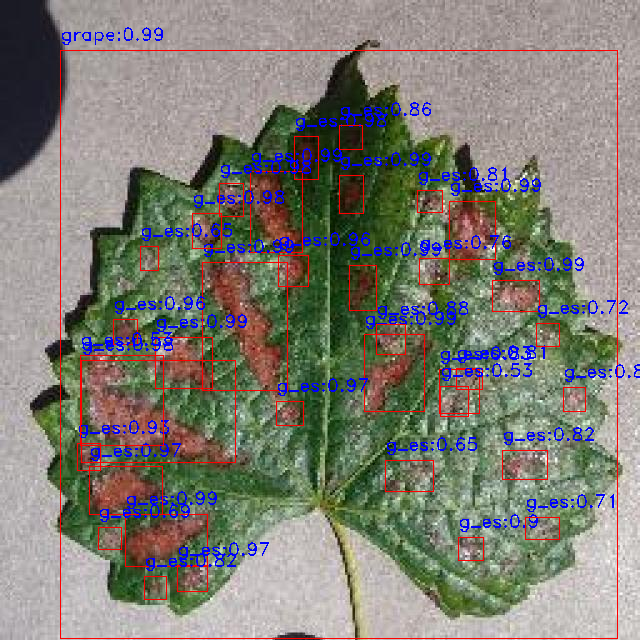

In [10]:
image_path = "D:/yolo/v8_cam/sampledata/Test (17).jpg"
img = Image.open(image_path).convert("RGB") 
img_np = np.array(img)
transform_info = CocoDataset.transform_image_for_inference(image_path,width=640,height=640)
result = IF_C.infer_image(transform_info=transform_info,
                        visualize=False)


if len(result)>0:
    for score in result['scores']:
        if score >= 0.50:
            score_index = result["scores"].index(score)
            # print(result["unscaled_boxes"][score_index])
            x, y, w, h = result["scaled_boxes"][score_index]
            cv2.rectangle(img_np, (int(x), int(y)), (int(w), int(h)), (255, 0, 0), 1)
        cv2.putText(img_np,f'{result["pred_classes"][score_index]}:{str(round(score,2))}', (int(x), int(y)-10), 2, 0.6, (0,0,255), 1)
        img_pil = Image.fromarray(np.uint8(img_np))
    # # img_pil.show()
    print(f"Classes: {result['pred_classes']}")
    # img_pil.save(f'output.jpg')
    display(img_pil)

### CAM

In [11]:
pred_boxes = result['scaled_boxes']
pred_labels = result['labels']
pred_classes = result['pred_classes']

In [12]:
image = img
# Convert the PIL image to a numpy array
image_np = np.array(image)

# Convert the numpy array to float32 and normalize it
image_float_np = np.float32(image_np) / 255

# Define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Apply the transforms to the image
input_tensor = transform(image)

# Check if GPU is available, and move the input tensor to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Add a batch dimension
input_tensor = input_tensor.unsqueeze(0)


In [13]:
# Load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model = IF_C.model
model.eval().to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
COLORS = np.random.uniform(0, 255, size=(len(class_list), 3))

In [15]:

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

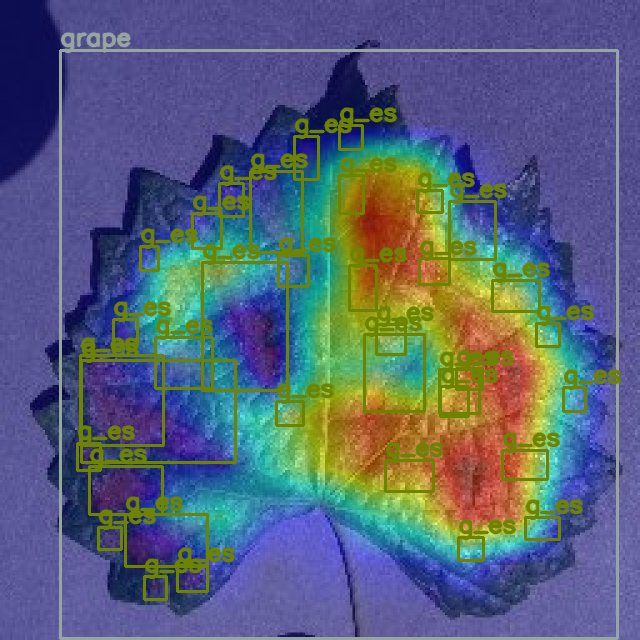

In [16]:
target_layers = [model.backbone]
targets = result
cam = EigenCAM(model,
               target_layers,
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:

image_with_bounding_boxes = draw_boxes(pred_boxes, pred_labels, pred_classes, cam_image)
Image.fromarray(image_with_bounding_boxes)



### Saliency Score

In [72]:
def saliency_frcnn(cam, img, threshold=0.2):
    """
    Compute the saliency score of CAM regions by calculating the average gradient magnitude within those regions.

    Args:
        cam (numpy.ndarray): CAM (Class Activation Map) of the image.
        img (numpy.ndarray): Original input image.
        threshold (float): Threshold value to determine the regions to compute saliency score.

    Returns:
        float: Saliency score.
    """
    # Threshold the CAM to obtain binary mask
    mask = np.uint8(cam > threshold)

    # Compute the gradient of the grayscale image
    gradient_x = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Compute the saliency score
    saliency_frcnn = np.mean(gradient_magnitude * mask)

    return saliency_frcnn

# Calculate Saliency Score
score_frcnn = saliency_frcnn(grayscale_cam, image_np)  # Pass the original input image
print("Saliency Score:", score_frcnn)


Saliency Score: 37.78247760550708


In [75]:
frcnn_saliency = score_frcnn
print(frcnn_saliency)


37.78247760550708


In [91]:
import torch
import torchvision

# Assuming pred_boxes is a list of bounding box predictions
pred_boxes = torch.tensor(pred_boxes)
gt_boxes = torch.tensor(result['unscaled_boxes'])

# Calculate the IoU using the torchvision.ops.box_iou function
iou = torchvision.ops.boxes.box_iou(pred_boxes, gt_boxes)

# Initialize variables for sum and count of valid IoU values
total_iou_sum = 0
valid_iou_count = 0

# Iterate through the IoU tensor and sum up the valid IoU values
for i in range(iou.size(0)):
    for j in range(iou.size(1)):
        # Get the class name for the predicted bounding box
        pred_class = pred_classes[i]
        # Get the IoU value
        iou_value = iou[i, j].item()
        # Ignore values less than 0.5
        if iou_value >= 0.1:
            total_iou_sum += iou_value
            valid_iou_count += 1

# Calculate the average IoU value
frcnn_average_iou = total_iou_sum / valid_iou_count if valid_iou_count > 0 else 0

print("Average IoU value for bounding box  {:.2f}".format(frcnn_average_iou))


Average IoU value for bounding box  0.88


In [124]:
frcnn_iou = frcnn_average_iou * 100
print("Faster R-CNN IoU:", "{:.2f}".format(frcnn_iou))


Faster R-CNN IoU: 87.60


In [129]:
class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
model =  IF_C.model
conf = 0.20
img_resolution = 640

def detect_v8(image_path):
    start_time = time.time()  # Start time for measuring inference time
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    results = IF_C.infer_image(transform_info=transform_info,
                        visualize=False)
    end_time = time.time()  # End time for measuring inference time
    inference_time = end_time - start_time  # Calculate inference time
    return inference_time

parent_path = "D:/yolo/v8_cam/sampledata"
image_list = [os.path.join(parent_path,i) for i in os.listdir(parent_path)]
random.shuffle(image_list)

total_inference_time = 0  # Initialize total inference time
individual_inference_times = []  # List to store individual inference times

# Collect individual inference times
for image_path in image_list:
    inference_time = detect_v8(image_path)
    individual_inference_times.append(inference_time)
    total_inference_time += inference_time  # Accumulate inference time

# Write to CSV file
csv_path = "D:/yolo/v8_cam/Inference_csv/inference_times1.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Inference Time (seconds)"])  # Header
    for image_path, inference_time in zip(image_list, individual_inference_times):
        writer.writerow([os.path.basename(image_path), inference_time])
    writer.writerow(["Total Inference Time", total_inference_time])  # Write total inference time

print("CSV file created successfully at:", csv_path)


CSV file created successfully at: D:/yolo/v8_cam/Inference_csv/inference_times1.csv


In [130]:
print("Total Inference Time:", total_inference_time, "seconds")


Total Inference Time: 50.80637240409851 seconds


### YOLOV8

In [50]:
import ultralytics
from ultralytics import YOLO

In [52]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [53]:
plt.rcParams["figure.figsize"] = [3.0, 3.0]

In [54]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [55]:
model = YOLO('models/best.pt')

In [56]:
img = cv2.imread('sampledata/Test (17).JPG')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [57]:
target_layers =[model.model.model[-4]]


0: 640x640 35 g_ess, 1 grape, 296.0ms
Speed: 2.9ms preprocess, 296.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


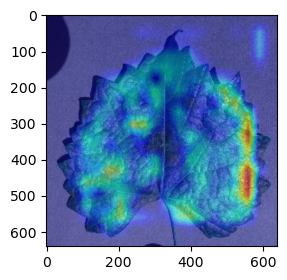

In [58]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

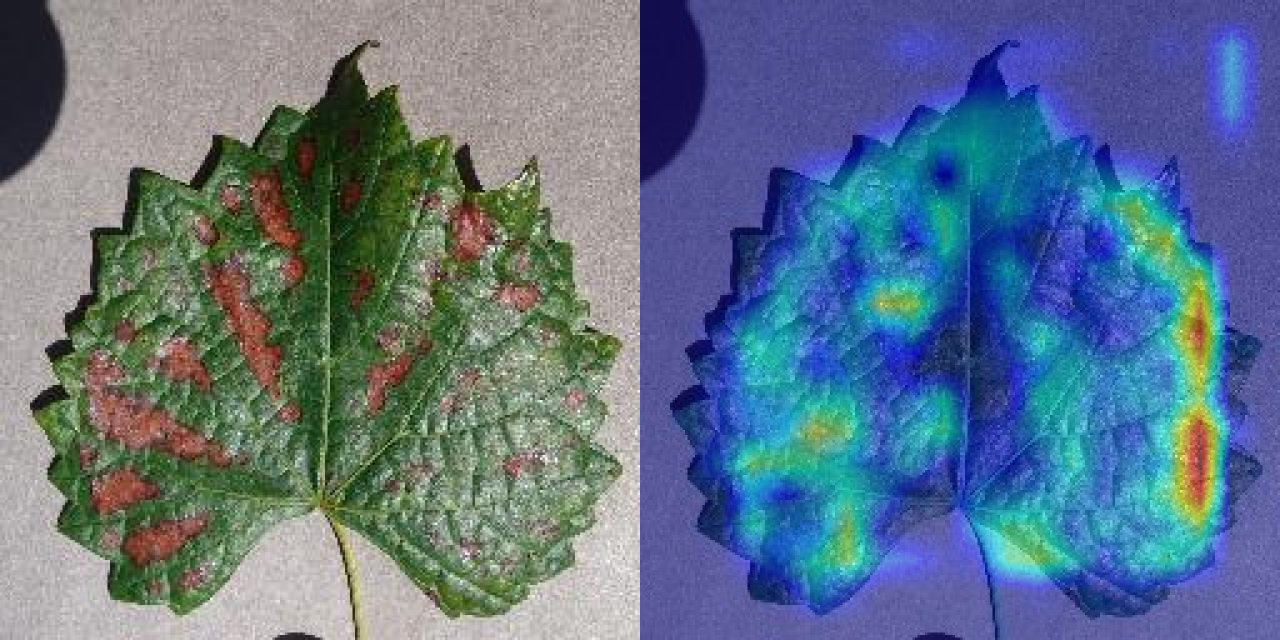

In [59]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [73]:
def saliency_score(cam, threshold=0.2):
    """
    Compute the saliency score of CAM regions by calculating the average gradient magnitude within those regions.

    Args:
        cam (numpy.ndarray): CAM (Class Activation Map) of the image.
        threshold (float): Threshold value to determine the regions to compute saliency score.

    Returns:
        float: Saliency score.
    """
    # Threshold the CAM to obtain binary mask
    mask = np.uint8(cam > threshold)
    
    # Compute the gradient of the grayscale image
    gradient_x = cv2.Sobel(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Compute the saliency score
    saliency_score = np.mean(gradient_magnitude * mask)
    
    return saliency_score

# Calculate Saliency Score
score = saliency_score(grayscale_cam)
print("Saliency Score:", score)


Saliency Score: 37.78956778832161


In [74]:
yolo_v8 = score
print(yolo_v8)


37.78956778832161



0: 640x640 2 p_lbs, 1 potato, 231.6ms
Speed: 0.0ms preprocess, 231.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


3
YOLOv8 IOU: 0.6481320974856476


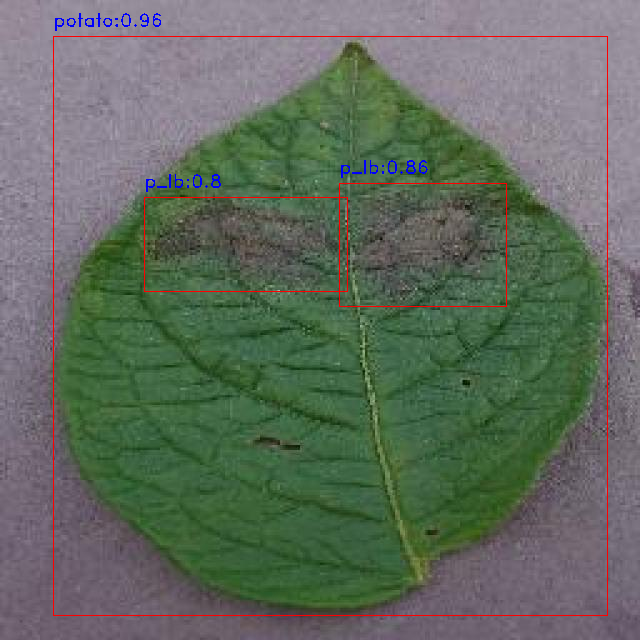

In [117]:
import os
import uuid
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from ultralytics import YOLO
import random

class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
model = YOLO("best.pt") 
conf = 0.10
img_resolution = 640

def calculate_iou(box1, box2):
    # Extract coordinates from boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection area
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Calculate area of intersection
    intersection_area = max(0, w_intersection) * max(0, h_intersection)

    # Calculate areas of both boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

def load_annotations(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        annotations = []
        for line in lines:
            values = line.strip().split()
            cls = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])
            # Convert from normalized coordinates to absolute coordinates
            x = (x_center - width / 2) * img_resolution
            y = (y_center - height / 2) * img_resolution
            w = width * img_resolution
            h = height * img_resolution
            annotations.append([x, y, w, h, cls])
        return annotations

def detect_v8(image_path, annotation_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img) 
    results = model.predict(source=img_np,
                            imgsz=img_resolution,
                            conf=conf,
                            )  
    tensor_list = results[0].boxes.data
    detection = tensor_list.tolist()
    total_products = len(detection)
    print(total_products)
    total_iou = 0
    for det in detection:
        confidence = det[4]
        x, y, w, h, _, cls = [int(d) for d in det]
        cv2.rectangle(img_np, (x, y), (w, h), (255, 0, 0), 1)
        cv2.putText(img_np,f'{str(class_list[cls])}:{str(round(confidence,2))}', (x, y-10), 2, 0.6, (0,0,255), 1)

        # Load ground truth annotations
        annotations = load_annotations(annotation_path)

        # Calculate IoU with ground truth bounding boxes
        for annotation in annotations:
            x_gt, y_gt, w_gt, h_gt, cls_gt = annotation
            iou = calculate_iou([x, y, w, h], [x_gt, y_gt, w_gt, h_gt])
            total_iou += iou

    yolov8_iou = total_iou / total_products
    print("YOLOv8 IOU:", yolov8_iou)

    img_pil = Image.fromarray(np.uint8(img_np))
    display(img_pil)

    return yolov8_iou

image_path = "iou/test.jpg"  # Provide the path to your image
annotation_path = "iou/test.txt"  # Provide the path to the corresponding annotation file
yolo_v8_iou = detect_v8(image_path, annotation_path)



In [123]:
yolo_iou = yolo_v8_iou * 100
print("Yolo IoU:", "{:.2f}".format(yolo_iou))


Yolo IoU: 64.81


In [131]:
import os
import time
import csv
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from ultralytics import YOLO
import random

class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
model = YOLO("best.pt") 
conf = 0.20
img_resolution = 640

def detect_v8(image_path):
    start_time = time.time()  # Start time for measuring inference time
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img) 
    results = model.predict(source=img_np,
                            imgsz=img_resolution,
                            conf=conf,
                            )  
    end_time = time.time()  # End time for measuring inference time
    inference_time = end_time - start_time  # Calculate inference time
    return inference_time

parent_path = "D:/yolo/v8_cam/sampledata"
image_list = [os.path.join(parent_path,i) for i in os.listdir(parent_path)]
random.shuffle(image_list)

total_inference_time_yolo = 0  # Initialize total inference time
individual_inference_times = []  # List to store individual inference times

# Collect individual inference times
for image_path in image_list:
    inference_time = detect_v8(image_path)
    individual_inference_times.append(inference_time)
    total_inference_time_yolo += inference_time  # Accumulate inference time

# Write to CSV file
csv_path = "D:/yolo/v8_cam/Inference_csv/inference_times.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Inference Time (seconds)"])  # Header
    for image_path, inference_time in zip(image_list, individual_inference_times):
        writer.writerow([os.path.basename(image_path), inference_time])
    writer.writerow(["Total Inference Time", total_inference_time_yolo])  # Write total inference time

print("CSV file created successfully at:", csv_path)



0: 640x640 3 p_lbs, 1 potato, 270.6ms
Speed: 0.0ms preprocess, 270.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 grape_healthy, 318.1ms
Speed: 0.0ms preprocess, 318.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 24 g_brs, 9 g_lbs, 1 grape, 293.0ms
Speed: 6.3ms preprocess, 293.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 potato_healthy, 351.6ms
Speed: 15.6ms preprocess, 351.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 potato_healthy, 264.0ms
Speed: 0.0ms preprocess, 264.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 g_ess, 1 grape, 269.4ms
Speed: 0.0ms preprocess, 269.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 a_ss, 14 p_ebs, 6 p_lbs, 1 potato, 283.7ms
Speed: 0.0ms preprocess, 283.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 g_

CSV file created successfully at: D:/yolo/v8_cam/Inference_csv/inference_times.csv


In [132]:
print("Total Inference Time:", total_inference_time_yolo, "seconds")


Total Inference Time: 7.8772618770599365 seconds


### COMPARISON FRCNN VS YOLOV8 SALIENCY SCORE

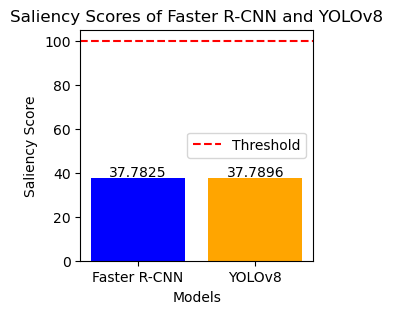

In [80]:
import matplotlib.pyplot as plt

# Scores from Faster R-CNN and YOLOv8
frcnn_saliency = score_frcnn
yolo_v8 = score

# Threshold value
threshold = 100

# Plotting
models = ['Faster R-CNN', 'YOLOv8']
scores = [frcnn_saliency, yolo_v8]

bar_colors = ['blue', 'orange']
plt.bar(models, scores, color=bar_colors)

# Adding values on top of bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.5, f'{score:.4f}', ha='center', color='black')

# Adding a horizontal line for the threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Labels and title
plt.xlabel('Models')
plt.ylabel('Saliency Score')
plt.title('Saliency Scores of Faster R-CNN and YOLOv8')
plt.legend()

# Show the plot
plt.show()


### COMPARISON FRCNN VS YOLOV8 IoU SCORE

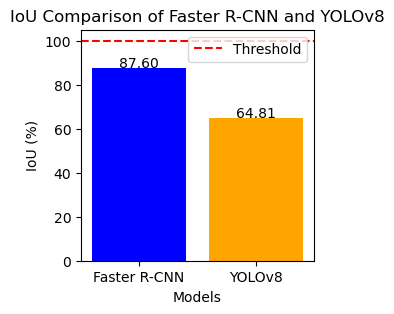

In [128]:
import matplotlib.pyplot as plt

# IoU values for Faster R-CNN and YOLOv8
frcnn_iou = frcnn_average_iou * 100
yolo_iou = yolo_v8_iou * 100

# Threshold value
threshold_iou = 100

# Plotting
models = ['Faster R-CNN', 'YOLOv8']
ious = [frcnn_iou, yolo_iou]

bar_colors = ['blue', 'orange']
plt.bar(models, ious, color=bar_colors)

# Adding values on top of bars
for i, iou in enumerate(ious):
    plt.text(i, iou + 0.5, "{:.2f}".format(iou), ha='center', color='black')

# Adding a horizontal line for the threshold
plt.axhline(y=threshold_iou, color='r', linestyle='--', label='Threshold')

# Labels and title
plt.xlabel('Models')
plt.ylabel('IoU (%)')
plt.title('IoU Comparison of Faster R-CNN and YOLOv8')
plt.legend()

# Show the plot
plt.show()


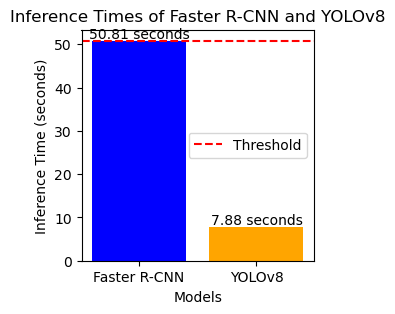

In [133]:
import matplotlib.pyplot as plt
# Total inference times for Faster R-CNN and YOLOv8
total_inference_time_frcnn = total_inference_time
total_inference_time_yolo = total_inference_time_yolo
# Dynamic threshold calculation
threshold = max(total_inference_time_frcnn, total_inference_time_yolo)
# Plotting
models = ['Faster R-CNN', 'YOLOv8']
inference_times = [total_inference_time_frcnn, total_inference_time_yolo]
bar_colors = ['blue', 'orange']
plt.bar(models, inference_times, color=bar_colors)
# Adding values on top of bars
for i, time in enumerate(inference_times):
    plt.text(i, time + 0.5, f'{time:.2f} seconds', ha='center', color='black')
# Adding a horizontal line for the threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# Labels and title
plt.xlabel('Models')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Times of Faster R-CNN and YOLOv8')
plt.legend()
# Show the plot
plt.show()
